<a href="https://colab.research.google.com/github/AzeemSyed123/CIFAR0-Automobile-GAN/blob/main/AbdulAzeemSyed_GAN_Automobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am implementing a Generative Adversarial Network (GAN) using TensorFlow/Keras to generate images of automobiles from the CIFAR-10 dataset.


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import time


### Generator Architecture

The generator network takes a random noise vector (latent_dim=100) as input and transforms it into an image. The architecture uses `Dense` layers followed by `Reshape`, `BatchNormalization`, and `LeakyReLU` activations. It then employs `Conv2DTranspose` (deconvolutional) layers to upsample the spatial dimensions, progressively increasing the image size until it reaches the desired output shape of 32x32x3 (height, width, channels). The final layer uses a `Conv2D` with a `tanh` activation to output pixel values in the range of [-1, 1].

### Discriminator Architecture

The discriminator network takes an image (either real from the dataset or fake from the generator) as input and outputs a single value indicating whether the image is real or fake. The architecture consists of `Conv2D` layers with `strides` to downsample the spatial dimensions. `BatchNormalization` and `LeakyReLU` are used for normalization and activation, and `Dropout` is applied for regularization. The output is flattened and passed through a `Dense` layer with a single output, representing the discriminator's judgment.

In [ ]:
class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.batch_size = 64
        self.n_discriminator = 5
        self.lambda_gp = 10
        self.class_label = 1  # CIFAR-10 class for automobiles

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        self.g_optimizer = Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
        self.d_optimizer = Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(4 * 4 * 512, input_dim=self.latent_dim))
        model.add(Reshape((4, 4, 512)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(self.channels, kernel_size=3, padding="same", activation="tanh"))

        return model

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1))

        return model

    def gradient_penalty(self, real, fake):
        batch_size = tf.shape(real)[0]
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated = epsilon * real + (1 - epsilon) * fake
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def wasserstein_loss(self, y_true, y_pred):
        return tf.reduce_mean(y_true * y_pred)

    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        for _ in range(self.n_discriminator):
            noise = tf.random.normal([batch_size, self.latent_dim])
            with tf.GradientTape() as tape:
                fake_images = self.generator(noise, training=True)
                real_output = self.discriminator(real_images, training=True)
                fake_output = self.discriminator(fake_images, training=True)
                gp = self.gradient_penalty(real_images, fake_images)
                d_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + self.lambda_gp * gp
            gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, self.latent_dim])
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_output)
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # Calculating accuracy
        real_accuracy = tf.reduce_mean(tf.cast(real_output < 0, tf.float32))
        fake_accuracy = tf.reduce_mean(tf.cast(fake_output >= 0, tf.float32))
        accuracy = (real_accuracy + fake_accuracy) / 2

        return d_loss, g_loss, accuracy

    def train(self, epochs, save_interval=100):
        # Loading the dataset
        (x_train, y_train), (_, _) = cifar10.load_data()
        x_train = x_train[y_train.flatten() == self.class_label]
        x_train = x_train.astype('float32')
        x_train = (x_train - 127.5) / 127.5  # Scale to [-1, 1]
        dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(self.batch_size)

        for epoch in range(epochs):
            start = time.time()
            d_loss_total = 0
            g_loss_total = 0
            accuracy_total = 0
            num_batches = 0
            for real_images in dataset:
                d_loss, g_loss, accuracy = self.train_step(real_images)
                d_loss_total += d_loss
                g_loss_total += g_loss
                accuracy_total += accuracy
                num_batches += 1

            d_loss_avg = d_loss_total / num_batches
            g_loss_avg = g_loss_total / num_batches
            accuracy_avg = accuracy_total / num_batches
            print(f"Epoch: {epoch}, Discriminator Loss: {d_loss_avg:.4f}, Generator Loss: {g_loss_avg:.4f}, Accuracy: {accuracy_avg:.4f}, Time: {time.time()-start:.2f}")

            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = tf.random.normal((r * c, self.latent_dim))
        gen_imgs = self.generator(noise, training=False)

        gen_imgs = tf.clip_by_value(0.5 * gen_imgs + 0.5, 0.0, 1.0)

        fig, axs = plt.subplots(r, c, figsize=(5, 5))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt].numpy())
                axs[i, j].axis('off')
                cnt += 1
        os.makedirs("automobile_images", exist_ok=True)
        fig.savefig(f"automobile_images/epoch_{epoch}.png")
        plt.close(fig)



### Training Architecture (WGAN-GP)

This GAN is trained using the Wasserstein GAN with Gradient Penalty (WGAN-GP) approach. This method uses the Wasserstein loss function, which is more stable than the standard GAN loss, and adds a gradient penalty to enforce the Lipschitz constraint on the discriminator.

The `train_step` function outlines the training process:
- **Discriminator Training**: The discriminator is trained multiple times (`self.n_discriminator`) for each generator training step. It calculates the Wasserstein loss using real and fake images and adds the gradient penalty (`self.gradient_penalty`). The gradients are then applied using the Adam optimizer.
- **Generator Training**: The generator is trained to minimize the negative of the discriminator's output for fake images. This encourages the generator to produce images that fool the discriminator into classifying them as real. The gradients are applied using the Adam optimizer.

The `train` function iterates through epochs, feeding batches of real images to the `train_step` function and periodically saving generated images using `save_imgs`.

In [ ]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=1000, save_interval=50)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch: 0, Discriminator Loss: -9.9159, Generator Loss: 10.5936, Accuracy: 0.1842, Time: 39.36
Epoch: 1, Discriminator Loss: -6.1920, Generator Loss: 11.5294, Accuracy: 0.4340, Time: 3.99
Epoch: 2, Discriminator Loss: -5.5497, Generator Loss: 10.3906, Accuracy: 0.4615, Time: 4.00
Epoch: 3, Discriminator Loss: -3.6774, Generator Loss: 6.2827, Accuracy: 0.3973, Time: 4.03
Epoch: 4, Discriminator Loss: -2.9371, Generator Loss: 2.1767, Accuracy: 0.2639, Time: 4.03
Epoch: 5, Discriminator Loss: -2.7474, Generator Loss: 0.8667, Accuracy: 0.2796, Time: 3.97
Epoch: 6, Discriminator Loss: -2.4811, Generator Loss: 0.2625, Accuracy: 0.3252, Time: 4.00
Epoch: 7, Discriminator Loss: -2.3030, Generator Loss: -0.3764, Accuracy: 0.3306, Time: 4.00
Epoch: 8, Discriminator Loss: -2.3310, Generator Loss: 0.7747, Accuracy: 0.3018, Time: 4.03
Epoch: 9, Discriminator Loss: -2.3598, Generator Loss: 1.7381, Accuracy: 0.3065, Time: 4.01
Epoch: 10, Discriminator Loss: -2.3020, Generator Loss: 1.5287, Accuracy: 0

#Demonstrating Noise Vector Control

1. Testing fixed noise consistency:
Images identical: True


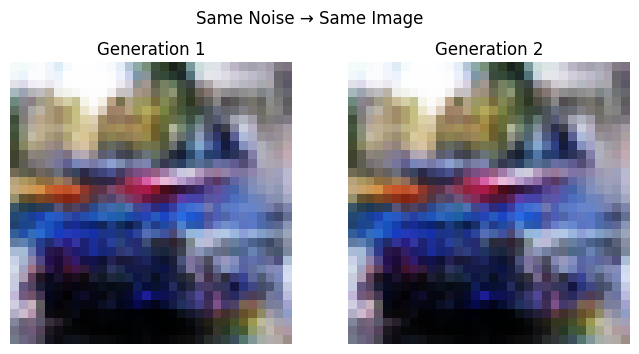


2. Noise interpolation:


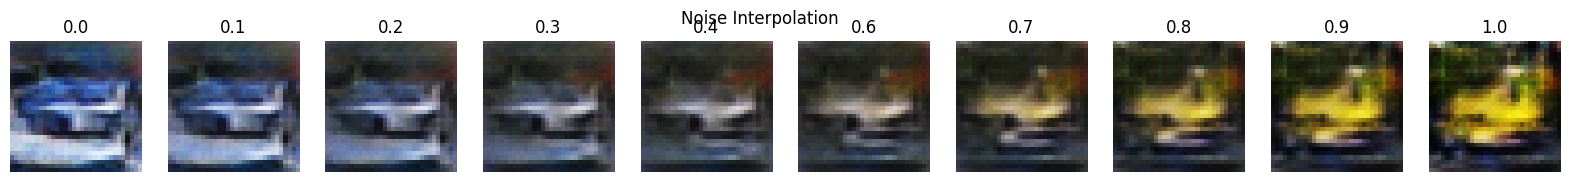


3. Varying single noise dimension:


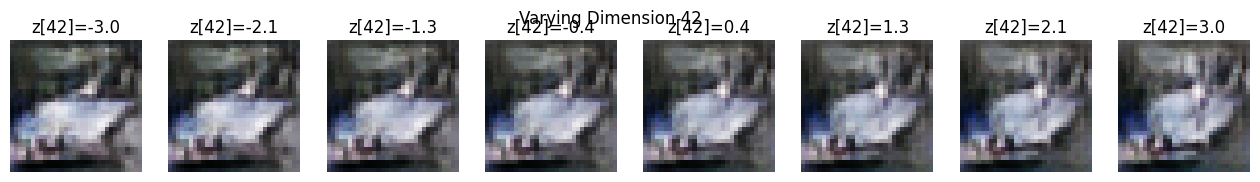


4. 2D latent space exploration:


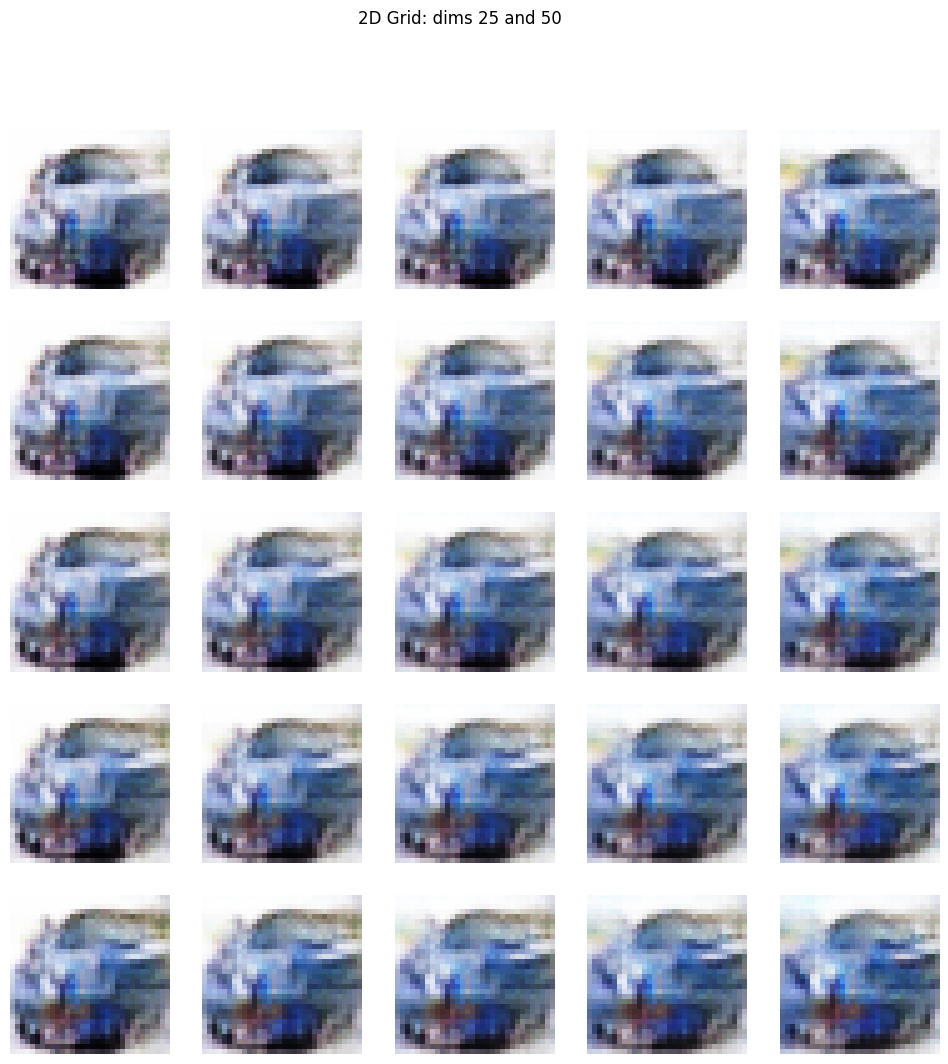

In [ ]:
# 1. Fixed Noise Consistency
print("1. Testing fixed noise consistency:")
if 'gan' not in locals():
    gan = GAN()
fixed_noise = np.random.normal(0, 1, (1, gan.latent_dim))
img1 = gan.generator(fixed_noise, training=False)
img2 = gan.generator(fixed_noise, training=False)
print(f"Images identical: {np.allclose(img1, img2)}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for idx, img in enumerate([img1[0], img2[0]]):
    axes[idx].imshow((img + 1) / 2)
    axes[idx].axis('off')
    axes[idx].set_title(f'Generation {idx+1}')
plt.suptitle('Same Noise → Same Image')
plt.show()

# 2. Interpolation
print("\n2. Noise interpolation:")
noise1 = np.random.normal(0, 1, (1, gan.latent_dim))
noise2 = np.random.normal(0, 1, (1, gan.latent_dim))

steps = 10
fig, axes = plt.subplots(1, steps, figsize=(20, 2))
for i, alpha in enumerate(np.linspace(0, 1, steps)):
    interp_noise = (1 - alpha) * noise1 + alpha * noise2
    gen_img = gan.generator(interp_noise, training=False)
    axes[i].imshow((gen_img[0] + 1) / 2)
    axes[i].axis('off')
    axes[i].set_title(f'{alpha:.1f}')
plt.suptitle('Noise Interpolation')
plt.show()

# 3. Single Dimension Variation
print("\n3. Varying single noise dimension:")
base_noise = np.random.normal(0, 1, (1, gan.latent_dim))
dim_to_vary = 42  # arbitrary dimension

steps = 8
fig, axes = plt.subplots(1, steps, figsize=(16, 2))
for i, value in enumerate(np.linspace(-3, 3, steps)):
    modified_noise = base_noise.copy()
    modified_noise[0, dim_to_vary] = value
    gen_img = gan.generator(modified_noise, training=False)
    axes[i].imshow((gen_img[0] + 1) / 2)
    axes[i].axis('off')
    axes[i].set_title(f'z[{dim_to_vary}]={value:.1f}')
plt.suptitle(f'Varying Dimension {dim_to_vary}')
plt.show()

# 4. 2D Grid
print("\n4. 2D latent space exploration:")
base_noise = np.random.normal(0, 1, (1, gan.latent_dim))
dim1, dim2 = 25, 50  # arbitrary dimensions

grid_size = 5
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
for i, val1 in enumerate(np.linspace(-2, 2, grid_size)):
    for j, val2 in enumerate(np.linspace(-2, 2, grid_size)):
        modified_noise = base_noise.copy()
        modified_noise[0, dim1] = val1
        modified_noise[0, dim2] = val2
        gen_img = gan.generator(modified_noise, training=False)
        axes[i, j].imshow((gen_img[0] + 1) / 2)
        axes[i, j].axis('off')
plt.suptitle(f'2D Grid: dims {dim1} and {dim2}')
plt.show()

### Effect of Controlling Noise Vector

The noise vector acts as a latent representation of the generated image. By manipulating this vector, we can explore the generator's learned image manifold and understand how different dimensions of the noise vector influence the generated image's characteristics. The final code cell demonstrates several ways to control the noise vector:

1.  **Fixed Noise Consistency**: Shows that the same noise vector consistently produces the same image, demonstrating the deterministic nature of the generator for a given input.
2.  **Interpolation**: By smoothly interpolating between two different noise vectors, we can observe a gradual transition between the corresponding generated images, suggesting that the latent space is continuous and meaningful.
3.  **Single Dimension Variation**: By varying a single dimension of the noise vector while keeping others constant, we can see how that specific dimension influences a particular aspect of the generated image (e.g., color, shape, orientation).
4.  **2D Grid**: By varying two dimensions of the noise vector across a 2D grid, we can visualize the interactions between these dimensions and explore a richer subspace of the latent space, revealing how combinations of features are learned.

These experiments highlight the generator's ability to map a structured latent space to the complex distribution of real images, allowing for controlled image synthesis.